# Introduction
**Summary:** An introductory tutorial to get things started with single cell RNA-seq analysis. This tutorial will describe the basic steps in a single cell RNA-seq analysis workflow including cell and gene quality control, normalization, batch correction, selection of highly variable genes, and visualization. Once described, we will leverage these techniques to identify and characterize T cell subsets and determine differences in these populations that result from virus infection.

Data required for workshop can be found at [Andersen Lab's Google Cloud](https://storage.cloud.google.com/andersen-lab_temp/dengue_all.hdf5). Download and move into the /data folder.

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import mygene
import wget

from rpy2.robjects import pandas2ri

pandas2ri.activate()

%load_ext rpy2.ipython

sc.settings.set_figure_params( dpi=80 )

/usr/local/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


# Dataset Selection
One benefit of the raise of single cell RNA-seq is the release of plentiful numbers of organism and cell type specific datasets. For this workshop, we'll be a dataset provided by Zanini et al. from their paper [Virus-inclusive single-cell RNA sequencing reveals the molecular signature of progression to severe dengue](https://doi.org/10.1073/pnas.1813819115).

In brief, blood samples were collected from four healthy controls and six individuals who presenting to a hospital in Columbia who met criteria for dengue virus infection. Two of the dengue-infected patients experienced an uncomplicated disease course characterized by flu-like symptoms while the other four experienced severe dengue manifestions.  Peripheral blood mononuclear cells were extracted and FACS was performed to enrich various broad immune cell types and to sort single cells in 384 well plates for a modified 5'-RACE RNA-seq library preparation. 

# Loading the data
The first thing to do is to load the data. In this case, it is provided as an .hdf5 file which, when loaded, represents an AnnData object. This is the format used by the Scanpy library which we'll be using for the majority of our analyses. This object can be thought of as a data matrix in which the rows and columns can be annotated with user-supplied or -generated metadata. A graphical representation is displayed below:

![AnnData Description](https://falexwolf.de/img/scanpy/anndata.svg)

This format can be used to organize single cell RNA-seq data. The data matrix (.X field) represents the count data itself, where the number of counts for a specific gene are recorded in each column for every cell, represented by a row:

| Gene | Cell_1 | Cell_2 | Cell_3 |
| ---- | ------ | ------ | -------|
| SNORA74 | 1 | 2 | 3 |   
| CCDC144B | 1 | 2 | 3 |
| LINC00430 | 0 | 1 | 0 |    


Individual cell annotions are found in the ".obs" field. We can add annotations like, what sample a cell belongs to, or what cell type it is, etc. Gene annotations are likewise found in the ".var" field. Unstructured annotations, those not pertaining to a specific gene or cell but to the whole dataset, are provided in the ".uns" field. Anndata objects can also contain multiple layers, which are alternatives to the ".X" field. For instance, when we log normalize our data as part of preprocessing, we can save the original raw count data as a layer for easy access later. While we won't make use of this functionality, the alternative layers can be accessed through the ".layer" dictionary.

Each of these fields, including the ".X" data matrix, are accessible in the same was as a pandas DataFrames with `.loc` and `.iloc` indexing. Subsetting the AnnData object will also subset its elements accordingly, so an operations like `anndata[list_of_genes,:]` will subset ".X", ".obs", and any layers you've created.

In [2]:
# Comment and point read_h5ad function towards downloaded dengue dataset.
scdata_file = wget.download( "https://storage.googleapis.com/andersen-lab_temp/dengue_all.hdf5" )

scdata = sc.read_h5ad( scdata_file )

# Preprocessing

The first step in single cell RNA-seq analysis is to prepare them for downstream analysis. We will perform the following steps:

1. **Filtration of cells and genes based on quality metrics**   
Low quality cells, resulting from damage during processing or incomplete capture, interfere with downstream analyses. Genes which provide little information are also removed to speed up computation.  
2. **Data normalization**  
Normalization eliminates cell/sample-specific biases in capture efficiency and enables explicit comparisons across cells.   
3. **Selection of features**  
This step selects genes which are variably expressed across cells. By limiting analysis to measurements of these genes we reduce computational requirements and noise from uninteresting or unexpressed genes.

## Quality Control
For single cell RNA-seq data, quality control needs to be performed on both cells and genes. To assess the quality of cells we'll use quality measures like the number of molecule counts, the number of genes expressed, and the fraction of counts of mitochondrial genes. 

In [3]:
# Quickly remove some meaningless annotation
scdata = scdata[:,:-6]

scdata.var["mito"] = scdata.var_names.str.startswith( "MT-" )
scdata.var["ERCC"] = scdata.var_names.str.startswith( "ERCC-" )
sc.pp.calculate_qc_metrics( scdata, qc_vars=[ 'mito', 'ERCC' ], inplace=True )

print( "Columns added:" )
for i in scdata.obs_keys():
    print( i )

print( "scdata contains {} cells with counts for {} genes".format( scdata.n_obs, scdata.n_vars ) )

Trying to set attribute `.var` of view, copying.


Columns added:
Age
Disease_Status
PatientID
Sex
Type
VirusReads
n_genes_by_counts
log1p_n_genes_by_counts
total_counts
log1p_total_counts
pct_counts_in_top_50_genes
pct_counts_in_top_100_genes
pct_counts_in_top_200_genes
pct_counts_in_top_500_genes
total_counts_mito
log1p_total_counts_mito
pct_counts_mito
total_counts_ERCC
log1p_total_counts_ERCC
pct_counts_ERCC
scdata contains 12263 cells with counts for 60715 genes


In the above code block we calculated all the quality measures we need to perform quality control on our cells. We can see that all together our datasets includes 3637 observations. While the majority of these are likely cells, this number is inflated by the presense of artifacts like dead cells, doublets, and barcode crosstalk. 

The first thing we'll look at is mitochondrial gene expression. Expression of mitocondrial genes is associated with poor quality cells which have lost cytoplasmic RNA for one reason or another. We'll examine a plot of the fraction of mitochondrial reads vs. number of molecules to determine what the thesholds should be for these quality metrics.

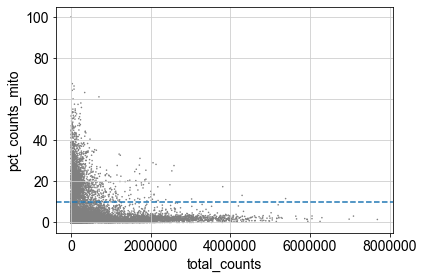

2499 observations (20.378%) will be removed with proposed mitochondrial limit


In [4]:
proposed_mt_limit = 10

ax = plt.subplot()
sc.pl.scatter( scdata, "total_counts", "pct_counts_mito", show=False, ax=ax )
plt.axhline( proposed_mt_limit, 0, 60000, linestyle="dashed" )
plt.show()

pct_removed = (scdata[scdata.obs["pct_counts_mito"] > proposed_mt_limit].n_obs / scdata.n_obs ) * 100

print( "{} observations ({:.3f}%) will be removed with proposed mitochondrial limit".format( scdata[scdata.obs["pct_counts_mito"] > proposed_mt_limit].n_obs, pct_removed ) )

In the plot we can see that there is a populations of cells with low molecule counts and a high fraction of mitochondrial gene expression. An appears as if an upper threshold of **10%** mitochondrial gene expression is appropriate so as to remove as much of this population as possible. 

Next we will look at cell size. We want to filter cells which contain either too little or too many molecule counts or total counts as these would be indicative of dead cells and multiplets, respectively. 

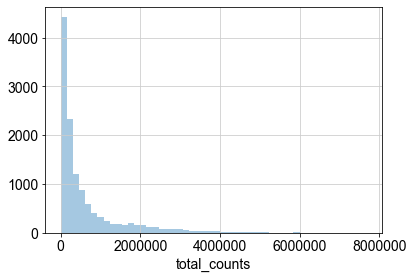

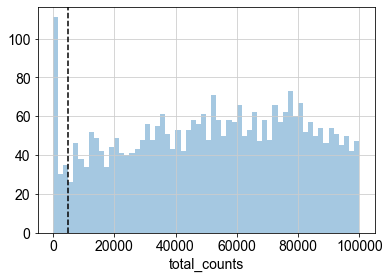

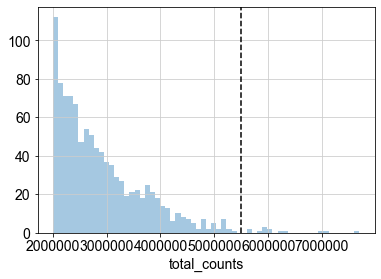

In [5]:
lower_counts = 5000
upper_counts = 5500000

#Thresholding decision: counts
sns.distplot( scdata.obs["total_counts"], kde=False )
plt.show()

sns.distplot( scdata.obs.loc[scdata.obs["total_counts"]<100000, "total_counts"], kde=False, bins=60 )
plt.axvline( lower_counts, 0, 100, linestyle="dashed", color="black" )
plt.show()

sns.distplot( scdata.obs.loc[scdata.obs["total_counts"]>2000000, "total_counts"], kde=False, bins=60 )
plt.axvline( upper_counts, 0, 20, linestyle="dashed", color="black" )
plt.show()

The histogram of the number of molecule counts per cell is normally distibuted with a peak around 60,000 reads per cell. The upper and lower limits of cell size are selected where the distribution lacks normality.

The histrogram of the number of counts per cells reveal a peak of cells with very few counts. Given the distribution of counts, these are likely to be uninformative and likely arise as a a result of debris or dead cells in wells.

Likewise, the histogram shows a number of outlier observations which contain massive numbers of counts (>5,500,000 reads). We will remove these as well.

The same basic analysis is performed on unique gene counts as well. 

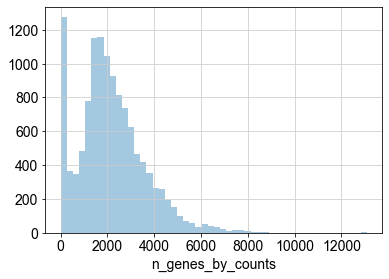

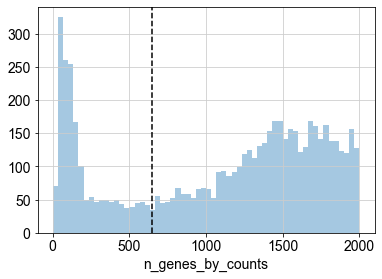

In [6]:
lower_genes = 650

scdata.obs["n_genes_by_counts"] = [row.count_nonzero() for row in scdata.X]

sns.distplot( scdata.obs["n_genes_by_counts"], kde=False )
plt.show()

sns.distplot( scdata.obs.loc[scdata.obs["n_genes_by_counts"] < 2000, "n_genes_by_counts"], kde=False, bins=60 )
plt.axvline( lower_genes, 0, 100, linestyle="dashed", color="black" )
plt.show()


In the histogram of unique gene counts per shows shows that a there is a large peak of cells expression a less than 500 genes. This peak is probably made up of either dead cells or wells that had only ambient RNA as input. 

Using these limits we will now filters the cells.

In [7]:
print( "Total number of cells: {}".format( scdata.n_obs ) )

scdata = scdata[scdata.obs["pct_counts_mito"] < proposed_mt_limit]
print( "Number of observations after MT filter: {}".format( scdata.n_obs ) )

sc.pp.filter_cells( scdata, min_genes=lower_genes )
print( "Number of observations after min genes filter: {}".format( scdata.n_obs ) )

sc.pp.filter_cells( scdata, min_counts=lower_counts )
print( "Number of observations after min count filter: {}".format( scdata.n_obs ) )

sc.pp.filter_cells( scdata, max_counts=upper_counts )
print( "Number of observations after max count filter: {}".format( scdata.n_obs ) )

Total number of cells: 12263
Number of observations after MT filter: 9763


Trying to set attribute `.obs` of view, copying.


Number of observations after min genes filter: 8188
Number of observations after min count filter: 8178
Number of observations after max count filter: 8165


The last filter we apply will be on genes. We only want to included in downstream analyses genes which are expressed in at least 2% of cells. We'll also remove the counts for the ERCC spike-ins. These provide useful metrics for normalization but we don't want to imply anything biological from their values.

In [8]:
proposed_gene_limit = 0.02

print( "Total number of genes: {}".format( scdata.n_vars ) )

# Filters out 0 count genes. Really 20 count genes.
sc.pp.filter_genes( scdata, min_cells=scdata.n_obs * proposed_gene_limit )
print( "Number of genes after cell filter: {}".format( scdata.n_vars ) )

# Remove ERCC spike-ins
scdata = scdata[:,~scdata.var["ERCC"]]

Total number of genes: 60715
Number of genes after cell filter: 17065


## Normalization
Currently, the data we've been working with is represented as counts which are representative of the molecules which were captures in the single cell RNA-seq experiment. Because these counts represent a sampling of the RNA in a cell the number of counts detected in a cell is a function of both the actual number of transcripts in a cell and the capture efficiency of those transcripts. We must then estimate the actual number of transcripts in a cell to be able to compare expression values between cells.  

We call the estimated number of transcripts in a cell the *size factor* of a cell. Normalized expression values for a cell can be determine by dividing the measured counts by the size factor of a cell. To calculate these size factors we'll use an approach implemented in *computeSizeFactors* function of the *scran* R package. In brief, this method computes a size factor for clusters of similar cells and then determines cell size factors by deconvoluting the cluster-based size factors. Many alternative methods exist, but a comparison performs by [Büttner et al. 2019](https://doi.org/10.1038/s41592-018-0254-1) found it to perform best.

To utilize this method, we'll quickly log normalize a copy of the data we have and use louvain clustering at a middling resolution to identify broad cell types. We'll then use these clusters when as input into the *computeSizeFactors* function. Later on in the tutorial we'll go into these steps in more depth.

In [9]:
scdata_copy = scdata.copy()
sc.pp.normalize_per_cell( scdata_copy, counts_per_cell_after=1e6, key_n_counts="total_counts" )
sc.pp.log1p( scdata_copy )
sc.pp.pca( scdata_copy, svd_solver="arpack", n_comps=15 )
sc.neighbors.neighbors( scdata_copy, n_pcs=15, use_rep="X_pca", random_state=42 )
sc.tl.louvain( scdata_copy, key_added="groups", resolution=0.5 )

input_groups = scdata_copy.obs["groups"]
data_mat = scdata.X.T.toarray()

Because *scran* is an R package, we need to use Rpy2 to interface with R. This block takes the cluster asignments and the transposed data matrix as input and returns a list size factors.

In [10]:
%%R -i data_mat -i input_groups -o size_factors
library( scran )

size_factors = computeSumFactors( data_mat, clusters=input_groups, min.mean=0.1, positive=TRUE )

R[write to console]: Loading required package: BiocParallel

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans

Trying to set attribute `.obs` of view, copying.


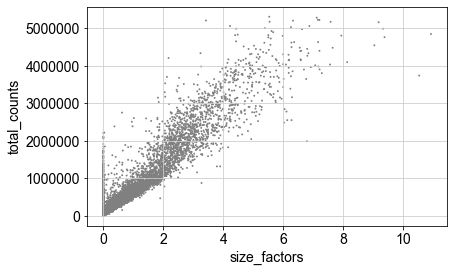

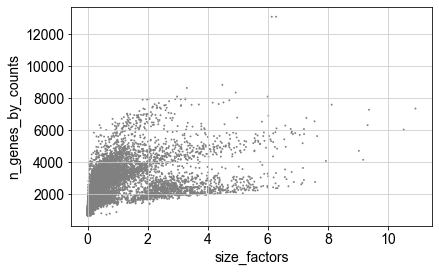

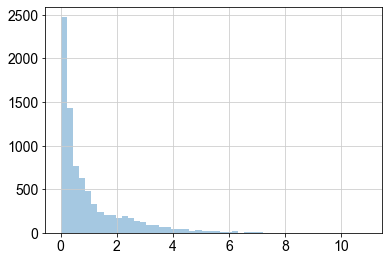

In [11]:
del scdata_copy

# Visualize the estimated size factors
scdata.obs["size_factors"] = size_factors

sc.pl.scatter( scdata, "size_factors", "total_counts" )
sc.pl.scatter( scdata, "size_factors", "n_genes_by_counts" )

sns.distplot( size_factors, bins=50, kde=False )
plt.show()

By plotting the size factors we can see that they correlate with the molecule counts and number of unique genes.=

Next we'll save the raw count data in a new layer for access later, normalize the data matrix by dividing by the size factors, and log transform the data. This transformation is necessary to identify strong relative differences between gene expression. 

In [12]:
#Keep the count data in a counts layer
scdata.layers["counts"] = scdata.X.copy()

#Normalize adata 
scdata.X /= scdata.obs["size_factors"].values[:,None]
sc.pp.log1p( scdata )
scdata.X = sp.sparse.csr_matrix( scdata.X )

# Store the full data set in 'raw' as log-normalised data for statistical testing
scdata.raw = scdata

## Batch Correction

As discussed earlier, the dataset contains cells from six different individuals. These samples were processed and sequenced individually so we need to identify and remove batch effects from the data. Batch effects and biological effects are often overlapping so any type of batch effect correction will necessarily remove some biological structure from the data. For this reason, we use the batch corrected data for clustering, but use the non-batch corrected data for calculating differential expression.

In [13]:
# ComBat batch correction
sc.pp.combat( scdata, key="PatientID" )

/usr/local/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py:338: RuntimeWarning: divide by zero encountered in true_divide
  change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())


## Highly Variable Genes
The clustering and dimensionality reduction which we intent to perfomr compare cells based on their gene expression profiles. However, not all genes provide useful information towards this end. Some are lowly expressed and their counts when present amount to noise in the data, while other provide interesting biological signal. We will remove the former group of genes and retain the latter to not only reduce the size of the dataset, but to highlight relevent biological structure.

To identify the useful set of genes we select from the genes with the highest variability; genes which are highly expressed in some cells, and lowly expressed in others. Here we use a technique of identifying highly variable genes from the Chromium 10x preprocessing software *CellRanger*. The number of genes to retain is an important decision. Enough genes need to be retains so as not to lose any biological signal, but not too many genes that noise is included from irrelevent genes. A number of strategies can be employed to determine the optimal amount (see [here](https://osca.bioconductor.org/feature-selection.html#hvg-selection)), but for our purposes we'll just select the top *n* genes. Typically between 1000 and 5000 genes are selected and for our analysis we'll include 4000. 

Number of highly variable genes: 4000


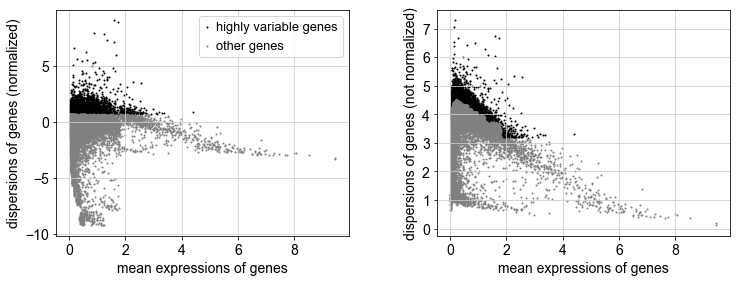

In [15]:
sc.pp.highly_variable_genes( scdata, flavor='cell_ranger', n_top_genes=4000 )
print( "Number of highly variable genes: {}".format( sum( scdata.var["highly_variable"] ) ) )

sc.pl.highly_variable_genes( scdata )

# Dimensionality Reduction
When analyzing single cell RNA-seq data, we aim to compare cells based on their expression across genes, i.e. to identify distinct transcriptomic profiles. However, expression of different genes may be correlated if they are affected by the same underlying biological process. In order to study these underlying biological processes, its necessary to compress the information from individual genes into a single dimension. Dimensionality reduction aims to reduce the number of dimensions needed to represent a dataset and presents a number of advantages:
* Reduces the computation load of downstream analyses.
* Reduced noise in dataset by averaging multiple correlated genes.
* Enables visualization of high dimensional dataset.


## Principal Component Analysis
The first technique we'll be using is Principal Component Analysis, or PCA. PCA reduces dimensionality by finding axes in the high dimensional data which capture the largest amount of variation. 

To perform PCA, an axis through the high dimensional data, also called a principal component (PC), is found which captures the greatest variance across cells. Next, another component is selected that is perpendicular to the first and captures the greatest remaining variance. This process can be repeated until a set number of principal components are found. 

Here we'll perform PCA on the normalized data and compute the first 50 principal components.

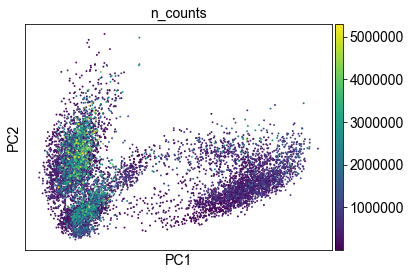

In [16]:
# Calculate the visualizations
sc.pp.pca( scdata, n_comps=50, use_highly_variable=True, random_state=42 )
sc.pl.pca( scdata, color="n_counts" )

In this plot we can already see distinct populations of cells, but, given that we've only plotted two principal components, its not that informative beyond that. One thing we can look at is the genes which contribute significantly to the first two principal components and ask whether they represent anything meaningful.

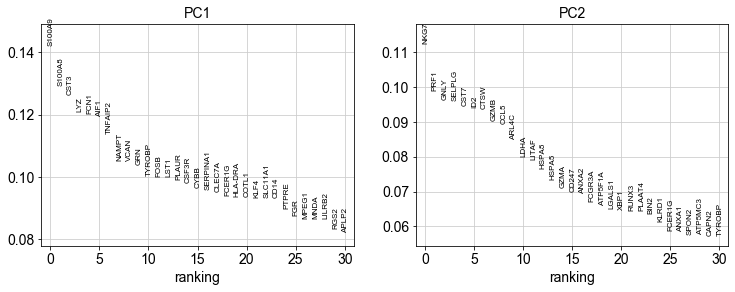

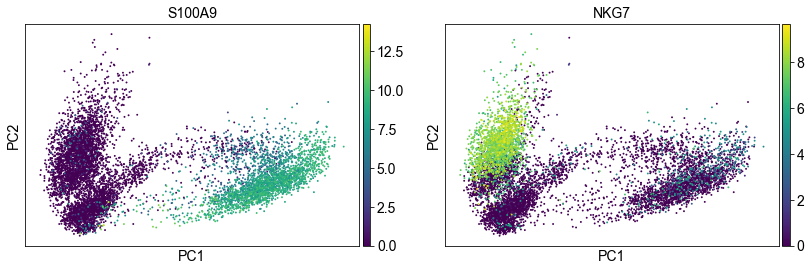

In [17]:
sc.pl.pca_loadings( scdata, components=[1,2], include_lowest=False )
sc.pl.pca( scdata, color=["S100A9", "NKG7"] )

We computed 50 principal components which represents a rather compact version of the dataset, though this is an arbitrary number. One question we can ask is how many principal components are neccessary to include for downstream analyses. Including more principal components means including more biological signal, but at the cost of more noise.

One heuristic we can use to select an appropriate number of principal components is an elbow plot, a plot which ranks principical components based on the percentage of variance they explain. We then include all principal components which lie above an elbow point on the plot where components above the point explain much more variance than the remaining components.

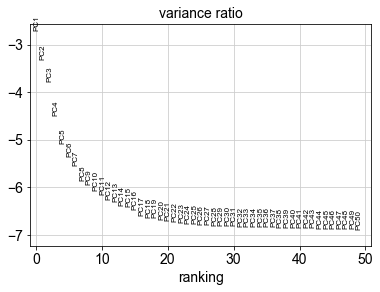

In [18]:
sc.pl.pca_variance_ratio( scdata, log=True, n_pcs=50 )

By looking at the graph we can see that we should probably include the top 17 principal components. Feel free to play around with the number of principal components to include and the effect it has on later analyses. A general rule is that true biological structure will be independent of the number of principal components included in clustering.

# Clustering
We'll now algorithmically define the populations of cells that we saw in the PCA plot with unsupervised clustering. 

The type of clustering we'll be performing is called graph-based clustering. First, we build a neighborhood graph where each node is a cell with edges connecting it to its nearest neighbors in terms of transcriptional profiles. Edges are then weighted based on the similarily to the neighboring cells. This graph is then used as input to a clustering algorithm which identifies clusters as cells which are more connected to eachother than to cells of other clusters.

In [19]:
sc.pp.neighbors( scdata, n_pcs=17, random_state=42 )

We next need to decide which clustering algorithm to use. There are essentially two commonly used algorithms, Louvain and Leiden, which are commonly used. Both iteratively group cells together and attempt to maximize the difference between the number of edges in a cluster and the number of edges expected to arise due to chance (modularity). We'll perform both and compare results to determine which is better for this dataset.

One other factor we need to consider is the resolution parameter which both algorithms require. This represents the granularity of the resulting clusters. Higher values generate a greater number of clusters and typically values of between 0.4 and 1.5 are seen depending on the size of the dataset. For our purposes, and since we only need to cluster broad cell types now, a resolution of 0.5 will be used.

In [20]:
sc.tl.leiden( scdata, resolution=0.5, key_added="leiden_r0.5", random_state=42 )
sc.tl.louvain( scdata, resolution=0.5, key_added="louvain_r0.5", random_state=42 )

To visualize the clustering results, we apply further dimensional reduction using a non-linear, unlike PCA, technique called UMAP. Similar to t-SNE, the UMAP algorithm attempts to accurately convey the local and global distances between cells' transcriptomic profiles in two dimensions.

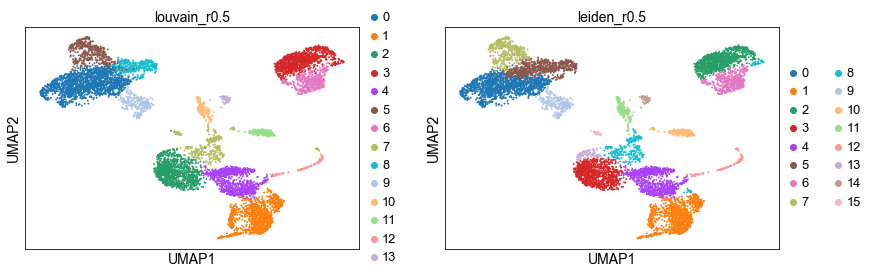

In [21]:
sc.tl.umap( scdata, random_state=42 )
sc.pl.umap( scdata, color=["louvain_r0.5", "leiden_r0.5"] )

The clustering results are fairly comparable and that is probably a result of the clustering algorithms being fairly similar. We'll use the leiden algorithm for the remainder of this tutorial as there are some arguments in the literature that it maintains well-connected communities better than louvain clustering (see [Traag et al. 2018](https://arxiv.org/ct?url=https%3A%2F%2Fdx.doi.org%2F10.1038%2Fs41598-019-41695-z&v=1b4d93af) for more information).

Feel free to compare the results with the louvain algorithm.

# T Cell Selection
To determine which of the clusters we just calculated correspond to T cells, we're going to look at the expression of canonical T cell markers, CD3 and the T cell receptor alpha constant chain, in these clusters.

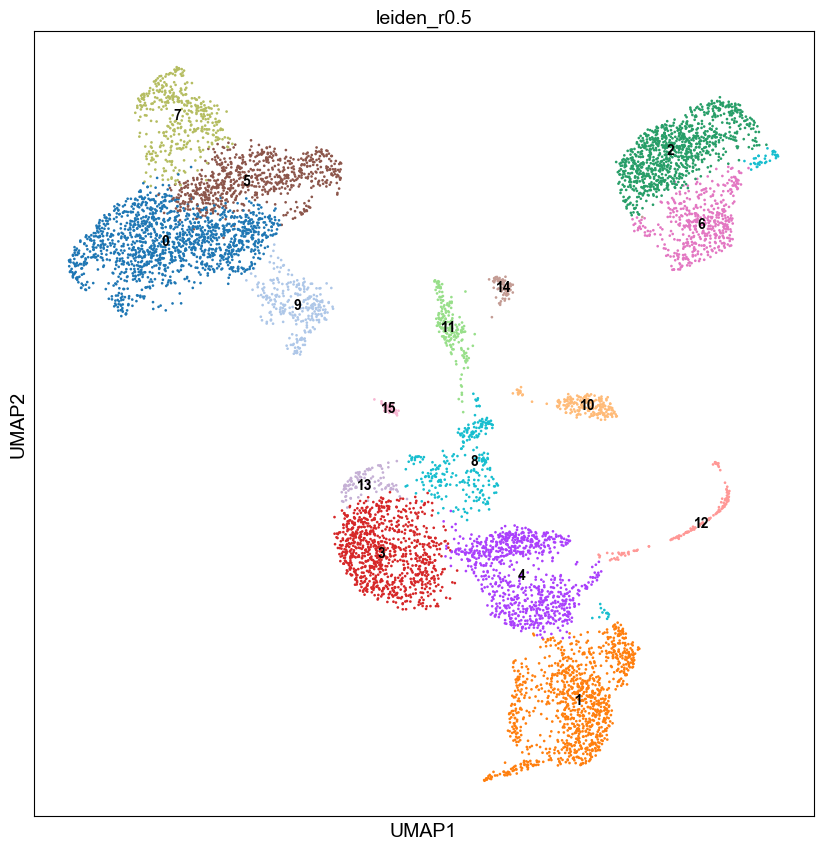

In [22]:
plt.figure( dpi=100, figsize=(10,10) )
ax = plt.subplot()
sc.pl.umap( scdata, color="leiden_r0.5", ax=ax, legend_loc="on data" )
plt.show()

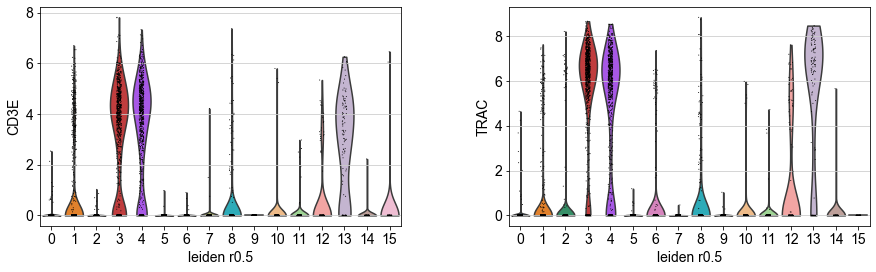

In [23]:
sc.pl.violin( scdata, ["CD3E", "TRAC"], groupby="leiden_r0.5" )

**Note: This may not be deterministic. Continue on your own, or have a look at the "Workshop_Notebook_complete" notebook for my results, if yours look different.**

By using the UMAP embeddings and the expression of canonical T cell markers, we can observe that T cells are likely found in clusters 3, 4, and 13 

Cluster 8 and 13 are also a candidate for containing T cells, but we won't include them in the T cell group. Both expresse some level of CD3 and TRAC, but that likely is a result of multiplets or other technical phenomenons. The other puntative T cell clusters group closely together in the UMAP embedding while putative T cells in clusters 8 and 13 are intermediate to larger non-T cell clusters and T cells. 

It is actually likely that all clusters contain some percentage of multiplet cells and cells which are incorrectly clusters. The next step in our analysis will be to identify cells in our putative T cell clusters that fit either of these cases using a method developed by [Szabo et al. 2019](https://doi.org/10.1038/s41467-019-12464-3). In brief, we generate a blacklist of genes that are overexpressed in non-T cell cluster and use those to remove contaminating cells in the T cell cluster.

In [24]:
# Merge and rename T cell cluster
scdata.obs["cluster"] = (scdata.obs["leiden_r0.5"]
                         .map(lambda x: {"3" : "T Cell", "4" : "T Cell", "13" : "T Cell"}.get(x, x) )
                         .astype("category") )
scdata.obs["cluster"].value_counts()

T Cell    1851
0         1428
1         1058
2          978
5          712
6          454
7          402
8          328
9          269
10         211
11         201
12         134
14          77
15          62
Name: cluster, dtype: int64

## Generate Blacklist
To generate the blacklist of genes, we conduct differential expression analysis pairwise between the T cell cluster and each non-T cell cluster. We then add all genes have an adjusted p-value of greater than 0.001 and greater than 5-fold enrichment in non-T cell clusters.

In [25]:
# Perform differential expression analysis, comparing each cluster with the putative T cell cluster.
sc.tl.rank_genes_groups( scdata, groupby="cluster", groups=[0,1,2,5,6,7,8,9,10,11,12,14,15], reference="T Cell", method="wilcoxon", use_raw=False, n_genes=-1 )

# Add differentially expressed genes for each cluster to the blacklist.
blacklist = list()
for i in ["0","1","2","5","6","7","8","9","10","11","12","14","15"]:
    blacklist_genes = (scdata.uns["rank_genes_groups"]["logfoldchanges"][i] > 5 ) & ( scdata.uns["rank_genes_groups"]["pvals_adj"][i] < 0.001 )
    blacklist.extend( scdata.uns["rank_genes_groups"]["names"][i][blacklist_genes] )
blacklist = np.unique( blacklist )
print( "{} genes added to the blacklist".format( len( blacklist ) ) )

/usr/local/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:362: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


1423 genes added to the blacklist


## Generate Whitelist 
We also generate a whitelist of genes which are positively enriched in any T cell cluster. In this way we avoid inclusion of genes which are differentially expressed in a limited number of T cells. 

We perform differential expression analysis again, but this time comparing all putative T cell clusters to all other identified clusters. We use the same requirements as noted for generating the gene blacklist.

In [26]:
# Perform differential expression analysis, comparing each of the T cell clusters to the rest of the clusters.
sc.tl.rank_genes_groups( scdata, groupby="leiden_r0.5", groups=[3,4,13], reference="rest", method="wilcoxon", use_raw=False, n_genes=-1 )

# Combine differentially expressed genes
whitelist = list()
for i in ["3", "4", "13"]:
    whitelist_genes = (scdata.uns["rank_genes_groups"]["logfoldchanges"][i] > 5 ) & ( scdata.uns["rank_genes_groups"]["pvals_adj"][i] < 0.001 )
    whitelist.extend( scdata.uns["rank_genes_groups"]["names"][i][whitelist_genes] )
whitelist = np.unique( whitelist )

print( "{} genes added to the whitelist".format( len( whitelist ) ) )
print( whitelist )

/usr/local/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


28 genes added to the whitelist
['A2M' 'CCL5' 'CCR7' 'CD3D' 'CD3G' 'CD8A' 'CST7' 'CTSW' 'GZMA' 'GZMK'
 'IFITM1' 'IL32' 'IL7R' 'KLRG1' 'LDHB' 'LEF1' 'LTB' 'MAL' 'NKG7' 'PRF1'
 'PRKCQ-AS1' 'TARP' 'TCF7' 'TRAC' 'TRAV1-2' 'TRBC1' 'TRBC2' 'TRGC2']


In [27]:
blacklist = [x for x in blacklist if x not in whitelist]
print( "{} genes ultimately in blacklist".format( len( blacklist ) ) )

1419 genes ultimately in blacklist


Typically, the T cell whitelist genes include those which we would typically call T cell marker genes. Broad T cell markers like *CD3*, *LTB*, and T cell receptor genes, cytotoxic markers like *GZMA* and *GZMK*, and cytokines like *CCL5*, *CCR7*, and *IL32*.

Thankfully, the whitelist only shared 4 genes with the blacklist.

## Remove Non-T cells
We'll now use the blacklist to remove cells which have been erroneously included in T cell clusters. We will then remove cells which express the blacklist genes above a certain threshold.

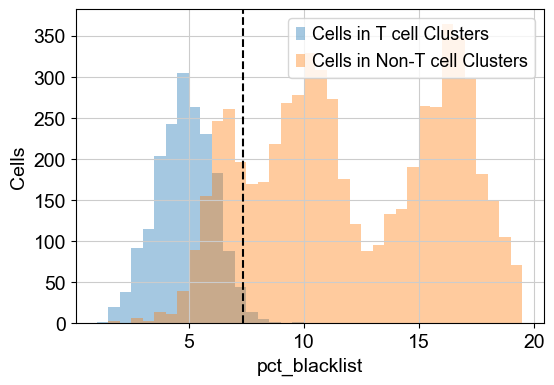

Threshold determined to be: 7.33%


In [28]:
# Calculate the percentage of normalized counts for blacklisted genes detected for each cell.
scdata.var["blacklist"] = scdata.var_names.isin( blacklist )
temp = sc.pp.calculate_qc_metrics( scdata, qc_vars=["blacklist"] )
scdata.obs["pct_blacklist"] = temp[0]["pct_counts_blacklist"]

# Calculate mean and absolute deviation of expression of blacklisted genes in T cell cluster.
mean_pct_blacklist = scdata.obs.loc[(scdata.obs["cluster"]=="T Cell"), "pct_blacklist"].mean()
mad_pct_blacklist = scdata.obs.loc[(scdata.obs["cluster"]=="T Cell"), "pct_blacklist"].mad()

# Plot distribution of blacklisted gene expression
plt.figure( dpi=100 )
ax = plt.subplot()
sns.distplot( scdata.obs.loc[(scdata.obs["cluster"]=="T Cell"), "pct_blacklist"], bins=np.arange(1,20,0.5), label="Cells in T cell Clusters", kde=False )
sns.distplot( scdata.obs.loc[(scdata.obs["cluster"]!="T Cell"), "pct_blacklist"], bins=np.arange(1,20,0.5), label="Cells in Non-T cell Clusters", kde=False )
plt.axvline( mean_pct_blacklist + 2.5*mad_pct_blacklist, 0, 20, linestyle="dashed", color="black" )
plt.ylabel( "Cells" )
plt.legend()
plt.show()

blacklist_threshold = mean_pct_blacklist + 2.5 * mad_pct_blacklist
print( "Threshold determined to be: {:.2f}%".format( blacklist_threshold ) )

Interestingly, and likely because of the high per-cell sequencing depth of this dataset, we see a certain amount of expression of the blacklisted genes in every cell. However, we can exploit the bi/tri-modal nature of the distribution of expression of the blacklisted genes to adequately filter T cells. Szabo et al. ascribes the expression of blacklisted genes in the T cell cluster to PCR recombination, where a molecule originating from one cell receives the cell-identifying barcode of a different cell at an intermediate point in PCR. 

We can see that the T cell distribution appears to be normally distributed with a slight positive skew. A simple threshold would then be anywhere from 2-3 mean absolute deviations above the mean of the T cell distribution. We use the mean absolute deviation here instead of the standard deviation because its less sensitive to outliers which this dataset doesn't have but others typically do. We consider any cell with expression of the blacklisted genes above this threshold and any cell in a non-T cell cluster to be a non-T cell and remove them from further analysis (Plot the dataset and color by cells below this threshold to see why we don't include all cells with expression of blacklisted genes below this threshold).

In [29]:
T_before = scdata.obs["cluster"].value_counts()["T Cell"]
scdata = scdata[(scdata.obs["cluster"]=="T Cell") & (scdata.obs["pct_blacklist"]<blacklist_threshold)]
T_after = scdata.n_obs

print( "Number of cells removed by blacklist gene filter: {}".format( T_before - T_after ) )
print( "Number of T cells identified: {}".format( T_after ) )

Number of cells removed by blacklist gene filter: 38
Number of T cells identified: 1813


# T Cell Clustering
Now that T cells have been identified, we'll cluster again to determine what populations we can identify. We will use the same procedure as before, calculating highly variable genes, dimensionality reduction, followed by clustering.

Trying to set attribute `.var` of view, copying.


Number of highly variable genes: 1999


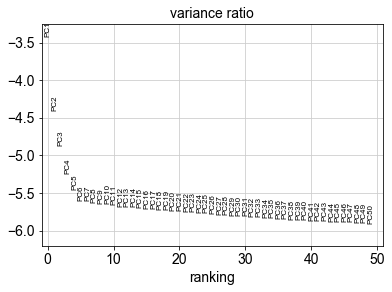

In [30]:
# Identify highly variable genes
sc.pp.highly_variable_genes( scdata, flavor='cell_ranger', n_top_genes=2000 )
print( "Number of highly variable genes: {}".format( sum( scdata.var["highly_variable"] ) ) )

# Dimensionality reduction using PCA
sc.pp.pca( scdata, n_comps=50, use_highly_variable=True, random_state=42 )
sc.pl.pca_variance_ratio( scdata, log=True, n_pcs=50 )

We lose a bit of structure, biological or otherwise, when limiting our analysis to T cells, so we only need to include the top 6 principal components for clustering.

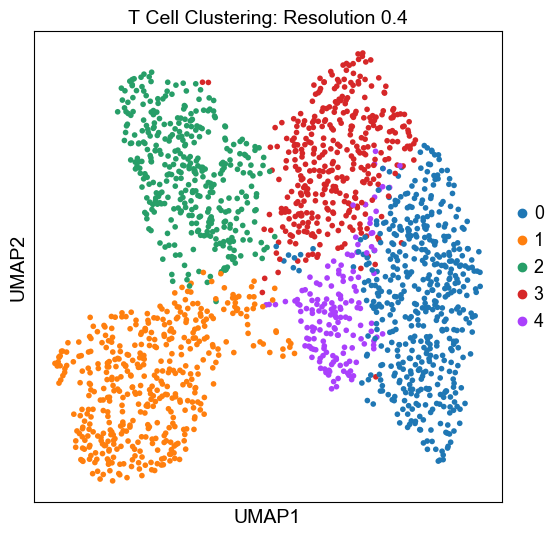

In [31]:
# Build neighborhood graph
sc.pp.neighbors( scdata, n_pcs=6, random_state=42 )

# Cluster at a middling resolution
sc.tl.leiden( scdata, resolution=0.4, key_added="subset", random_state=42 )

# Calculate UMAP embedding
sc.tl.umap( scdata, random_state=42 )

# 
plt.figure( dpi=100, figsize=(6,6) )
ax = plt.subplot()
sc.pl.umap( scdata, color=["subset"], ax=ax, title="T Cell Clustering: Resolution 0.4" )
plt.show()

Clustering has identified five T cell clusters. Playing around with the resolution parameter of the leiden function may find more or less clusters, though these five appear to be the most stable.

# T Cell Subset Characterization

## CD4 vs. CD8
The ultimate differentiator of T cells is whether they're CD4- or CD8-positive. We can visually assess this using the UMAP embedding and coloring each cell by the ratio of its expression of CD4 to CD8. Because drop-out, where a transcript is randomly not sample during the RNA-seq experiment, is quite common we'll color cells by the mean ratio of CD4 and CD8 in the cluster it has been assigned.

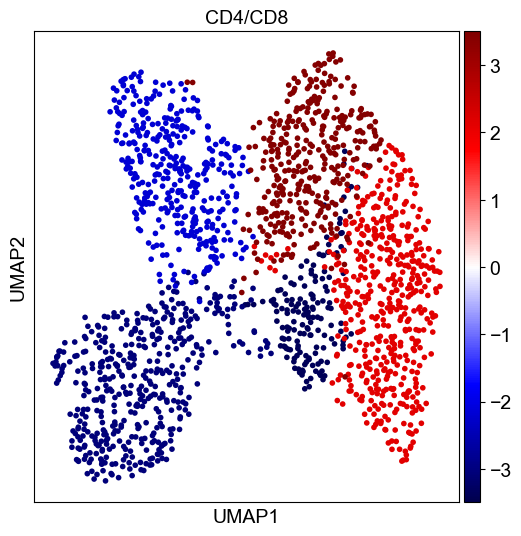

In [32]:
# Calculate the log ratio of CD4 to CD8 expression
scdata.obs["CD4"] = scdata[:,"CD4"].X
scdata.obs["CD8"] = scdata[:,"CD8A"].X
scdata.obs["CD4/CD8"] = scdata.obs.groupby("subset")["CD4"].transform( "mean" ) - scdata.obs.groupby( "subset" )["CD8"].transform( "mean" )
scdata.obs = scdata.obs.drop( columns=["CD4", "CD8"] )

plt.figure( dpi=100, figsize=(6,6) )
ax = plt.subplot()
sc.pl.umap( scdata, color=["CD4/CD8"], ax=ax, vmin=-3.5, vmax=3.5, color_map="seismic" )
plt.show()

Clusters 0 and 3 are likely CD4-positive T cells, while clusters 1, 2, and 4 are CD8-positive T cells.

## Subset Identification
To give sense to the identified subsets, besides merely CD4 and CD8 expression, we need to determine the genes whose expressions differentiates the clusters. We can then use these "marker" genes to assign clusters to canonical cell types and determine functional differences between clusters.

Marker genes are identified by their differential expression between clusters. Genes which are more strongly differentially expression are more likely to cause seperation between clusters of cells. To quantify differential expression we can use any number of statistical tests (t-test, wilcoxon test, linear regression) to make pairwise comparisons between clusters. For our purposes, we'll use the Wilcoxon rank sum test which is comparable to more complex methods. For a thorough comparison of differential expression methods, check out [Soneson and Robinson 2018](https://doi.org/10.1038/nmeth.4612).

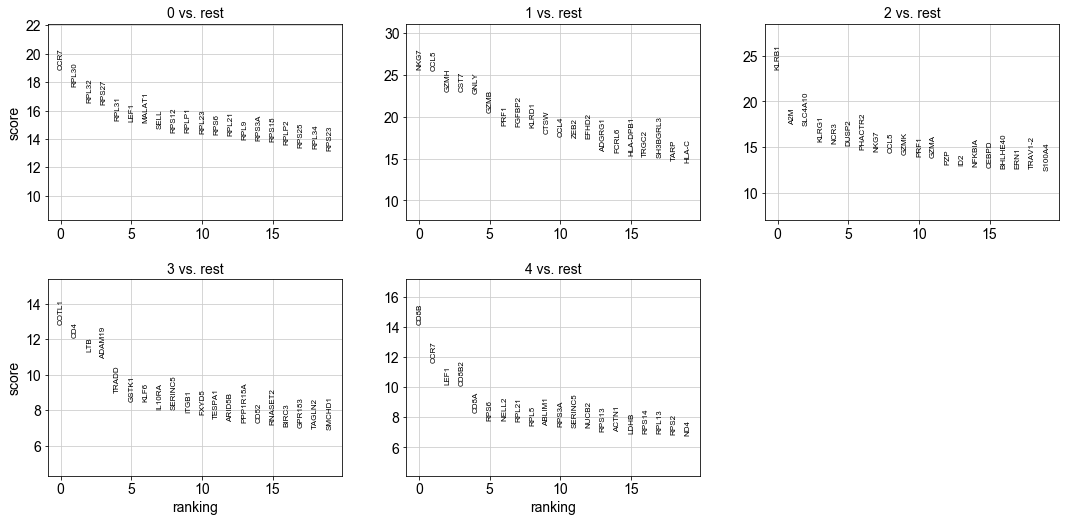

,0,1,2,3,4
0,CCR7,NKG7,KLRB1,COTL1,CD8B
1,RPL30,CCL5,A2M,CD4,CCR7
2,RPL32,GZMH,SLC4A10,LTB,LEF1
3,RPS27,CST7,KLRG1,ADAM19,CD8B2
4,RPL31,GNLY,NCR3,TRADD,CD8A
5,LEF1,GZMB,DUSP2,GSTK1,RPS6
6,MALAT1,PRF1,PHACTR2,KLF6,NELL2
7,SELL,FGFBP2,NKG7,IL10RA,RPL21
8,RPS12,KLRD1,CCL5,SERINC5,RPL5
9,RPLP1,CTSW,GZMK,ITGB1,ABLIM1


In [33]:
sc.tl.rank_genes_groups( scdata, groupby="subset", method="wilcoxon", use_raw=True, n_genes=100 )
sc.pl.rank_genes_groups( scdata, n_genes=20, ncols=3, sharey=False )

marker_genes = pd.DataFrame( scdata.uns["rank_genes_groups"]["names"] )
marker_genes.head(20)

We can now use the differentially expressed genes to determine what biological state is represented by each of the clusters. This isn't entirely straightforward and is likely the most challenging part of scRNA-seq analysis. An optimal identification method would be to look at the overlap of differentially expressed genes with a list of known markers genes, but often these aren't available for the more novel and less defined cell subsets we're looking at here. 

Below I've laid out the rational for how I would annotate the clusters.

Putative cluster labels:
- Cluster 0 - **CD4-C1-Resting** - Express markers of central memory and naive phenotype (*CCR7*, *SELL*), and resting (*LEF1*). Also express ribosomal genes indicating active translation.
- Cluster 1 - **CD8-C1-NKGY** - Cytotoxic T cell subset. Expresses markers of cytotoxicity (*PRF1*, *NKG7*, *GNLY*, *GZMH*), exhaustion (*CST7*). 
- Cluster 2 - **CD8-C2-KLRB1** - Cytotoxic T cell subset. Expresses markers of cytotoxicity (*KLRB1*, *KLRG1*, *NKG7*, *GZMK*, *PRF1*)
- Cluster 3 - **CD4-C2-Activated** - Activated T cell subset. Express markers of T cell motility, proliferation, and development (*COTL1*, *ADAM19*, *TRADD*, *GSTK1*, *ITGB1*)
- Cluster 4 - **CD8-C3-Resting** - Express markers of central memory and naive phenotype, and resting (*CCR7*)

We'll annotate the clusters so that downstream analysis is easier to read.

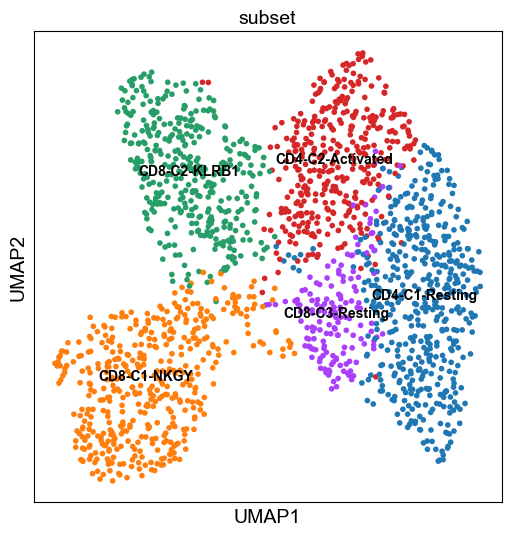

In [34]:
scdata.rename_categories( "subset", ["CD4-C1-Resting","CD8-C1-NKGY","CD8-C2-KLRB1","CD4-C2-Activated","CD8-C3-Resting"] )
scdata.obs["subset"].value_counts()

plt.figure( dpi=100, figsize=(6,6) )
ax=plt.subplot()
sc.pl.umap( scdata, color="subset", legend_loc="on data", show=False, ax=ax )
plt.show()

One other way we can look at these marker genes is through a heatmap of the highest differentially expressed genes. This will show us which clusters are most similar and how their markers genes are expressed in other clusters.

<Figure size 1200x800 with 0 Axes>

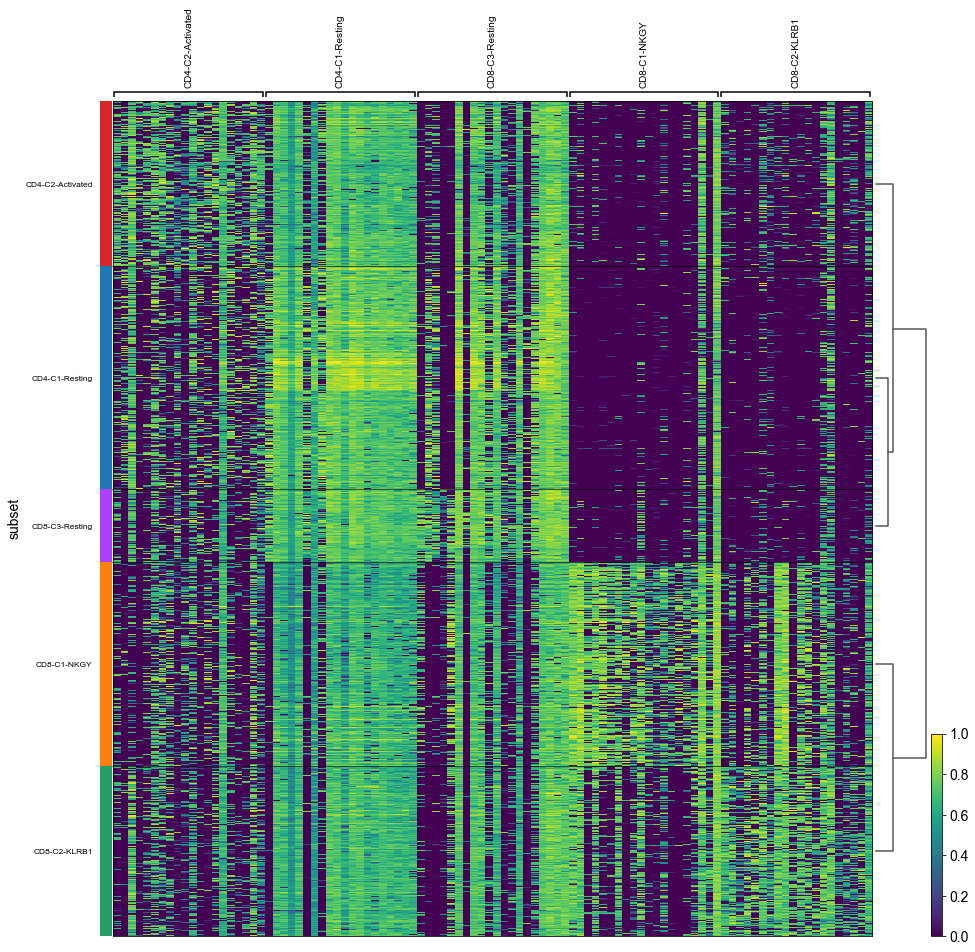

In [35]:
plt.figure( dpi=200 )
sc.pl.rank_genes_groups_heatmap( scdata, key="rank_genes_groups", n_genes=20, show=False, figsize=(15,15), standard_scale="var" )
plt.show()

Similar to the umap embeddings, T cell clusters mostly group together based on their CD4-/CD8-positive character and their activation state.

We can also see that differential gene expression analysis had difficulty determining marker genes for the resting CD4-/CD8-positive populations. Likely, these subsets are defined based on their lack of expression of certain activation markers, which we wouldn't see in this or the previous charts.

# T Cell Functional Comparison
The dataset we're using allows us to determine T cell-specific effects which differentiate acute and severe dengue fever.  

## Compositional Analysis
An initial comparison we can perform is a compositional one where we look at whether infection causes a significant difference in the size of various T cell populations. It should be noted that this type of analysis requires a sufficient number of cells to accurately asses populations sizes and account for expected variability. Unfortunately there are no dedicated tools to perform this type of analysis, so visual comparison of the composition is as informative as we can be.

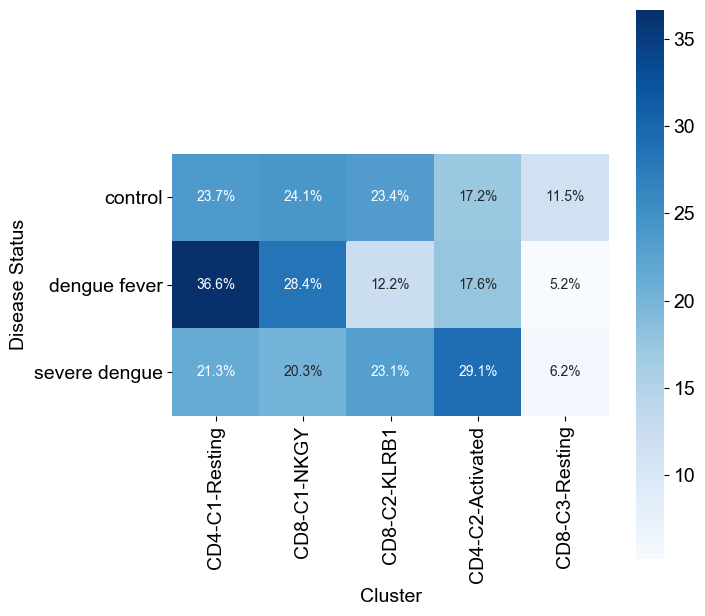

In [36]:
cells_patient = pd.crosstab( scdata.obs["Disease_Status"], scdata.obs["subset"] ).apply( lambda r: np.round( r/r.sum()*100, 2 ), axis=1 )
plt.figure( dpi=100, figsize=(7,7) )
ax=plt.subplot()
sns.heatmap( cells_patient, square=True, annot=True, fmt=".1f", cmap="Blues", ax=ax )
plt.xlabel( "Cluster" )
plt.ylabel( "Disease Status" )
for t in ax.texts: t.set_text(t.get_text() + "%")
plt.show()

In the above cross table we can see that patients with acute dengue fever have a higher proportion of resting CD4-positive T cells while patients with severe dengue fever have a high proportion of activated CD4-positive T cells. Acute dengue fever patients also have elevetated levels of one of cytotoxic CD8-positive T cell clusters, while individuals with severe dengue fail to see any elevation of these populations above control individual levels. 

To view this in another way, we can visualize shifts in cellular densities between disease statuses.

<Figure size 1200x800 with 0 Axes>

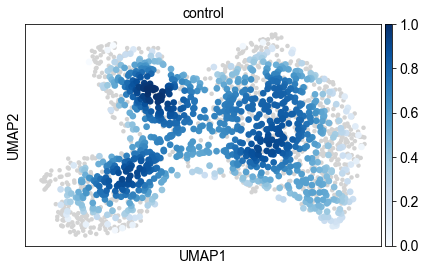

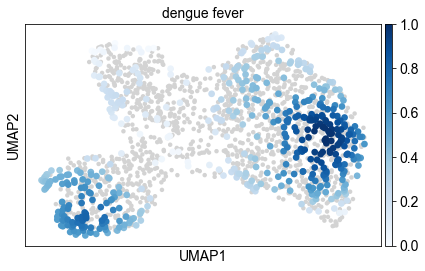

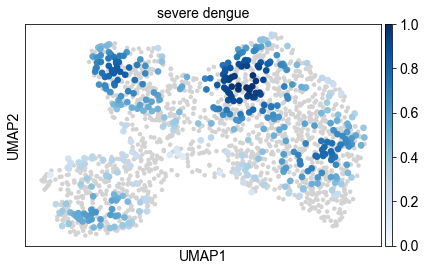

In [37]:
sc.tl.embedding_density( scdata, groupby="Disease_Status", key_added="umap_density_disease_status" )
plt.figure( dpi=200 )
sc.pl.embedding_density( scdata, key="umap_density_disease_status", group="control", color_map="Blues" )
sc.pl.embedding_density( scdata, key="umap_density_disease_status", group="dengue fever", color_map="Blues" )
sc.pl.embedding_density( scdata, key="umap_density_disease_status", group="severe dengue", color_map="Blues" )

Visually, there is a striking difference the proportion of the identified T cell clusters. Most clusters are evenly represented in the control individuals, while individuals with acute dengue and severe dengue show much higher proportions of activated subsets. Individuals with acute dengue fever fail to have an activated CD4-postive populations as large individuals with severe dengue fever. Both acute and severe dengue fever are associated with large populations of cytotoxic T cells, but these represented distinct populations. Additionally, because the size of this population in individuals with severe dengue is not visually different from the population in healthy individuals, it would seem that severe dengue correlates with the non-presense of suitable cytotoxic T cell populations for virus clearance.

This all seems to align with current literature where it has been suggested that both CD4- and CD8-postive T cell populations are import for clearance of dengue virus and progression to severe dengue results from immopathology as a result of the expansion of pre-existing crossreactive and low affinity memory T cell populations against the virus.

With this dataset we can also test the theory that the immunopathology associated with severe dengue results from the excess production of inflammatory cytokines. We'll look for evidence of their production in differentially expressed genes between acute and severe dengue fever. 

**Note**: Differentially expression between conditions is typically performed within clusters. Thus, we'll only look at differentially expressed genes within clusters which are likely to be producing cytokines, the activated CD4-postive and one of the activated CD8-positive populations.

Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


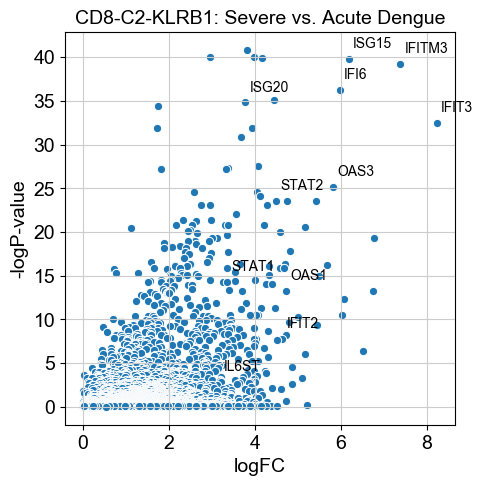

In [38]:
# Subset dataset
cd8_activated = scdata[scdata.obs["subset"]=="CD8-C2-KLRB1"]
cd4_activated = scdata[scdata.obs["subset"]=="CD4-C2-Activated"]

# Filter out genes which aren't expressed to reduced the number of hypothesies tested.
sc.pp.filter_genes( cd8_activated, min_cells=1 )
sc.pp.filter_genes( cd4_activated, min_cells=1 )

# Perform differential gene analysis
sc.tl.rank_genes_groups( cd8_activated, 
                         groupby="Disease_Status", 
                         groups=["severe dengue"], 
                         reference="dengue fever", 
                         key_added="severe_vs_acute",
                         method="wilcoxon",
                         n_genes=-1 )
sc.tl.rank_genes_groups( cd4_activated, 
                         groupby="Disease_Status", 
                         groups=["severe dengue"], 
                         reference="dengue fever", 
                         key_added="severe_vs_acute",
                         method="wilcoxon",
                         n_genes=-1 )

# Construct dataframe from results
cd4_results = cd4_activated.uns["severe_vs_acute"]
cd8_results = cd8_activated.uns['severe_vs_acute']
cd8_df = pd.DataFrame( { "names": cd8_results["names"]["severe dengue"],
                         "scores": cd8_results["scores"]["severe dengue"],
                         "logfoldchanges": cd8_results["logfoldchanges"]["severe dengue"], 
                         "pvals": cd8_results["pvals"]["severe dengue"],
                         "pvals_adj": cd8_results["pvals_adj"]["severe dengue"] } )
cd4_df = pd.DataFrame( { "names": cd4_results["names"]["severe dengue"],
                         "scores": cd4_results["scores"]["severe dengue"],
                         "logfoldchanges": cd4_results["logfoldchanges"]["severe dengue"], 
                         "pvals": cd4_results["pvals"]["severe dengue"],
                         "pvals_adj": cd4_results["pvals_adj"]["severe dengue"] } )

# Remove outlier genes
cd8_df["neglogpval_adj"] = -np.log( cd8_df["pvals_adj"] )
cd4_df["neglogpval_adj"] = -np.log( cd4_df["pvals_adj"] )
cd8_df = cd8_df.loc[cd8_df["logfoldchanges"]>0]
cd4_df = cd4_df.loc[cd4_df["logfoldchanges"]>0]
cd8_df = cd8_df.loc[cd8_df["logfoldchanges"]<15]
cd4_df = cd4_df.loc[cd4_df["logfoldchanges"]<15]

# Pull out genes to label
labels = ["IFI6", "IFITM3", "IFIT3", "IFIT2", "IL6ST", "ISG15", "ISG20", "STAT2", "STAT1", "OAS3", "OAS1" ]
labels_df = cd8_df.loc[cd8_df["names"].isin( labels )]
labels_df["logfoldchanges"] = labels_df["logfoldchanges"] + 0.1
labels_df["neglogpval_adj"] = labels_df["neglogpval_adj"] + 1.25

# Perform the plotting
plt.figure( dpi=100, figsize=(5,5) )
ax=plt.subplot()
sns.scatterplot( cd8_df["logfoldchanges"], cd8_df["neglogpval_adj"], ax=ax )
plt.xlabel( "logFC")
plt.ylabel( "-logP-value")
plt.title( "CD8-C2-KLRB1: Severe vs. Acute Dengue")
for i in labels_df.iterrows():
    ax.annotate( i[1]["names"], (i[1]["logfoldchanges"], i[1]["neglogpval_adj"]) )
plt.show()

In the activated CD8 cells, we don't see increased expression of any cytokines besides IL6. This isn't entirely unexpected because cytokine transcripts are produced in very few copies even when upregulated, and might not be present in the circulating T cell populations we've sampled. Instead, we can look at indirect measures of cytokine production. Genes related to the interferon response, including interferon inducible proteins genes and interferon stimulated genes, are significantly increased in the severe dengue compared to acute dengue fever.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


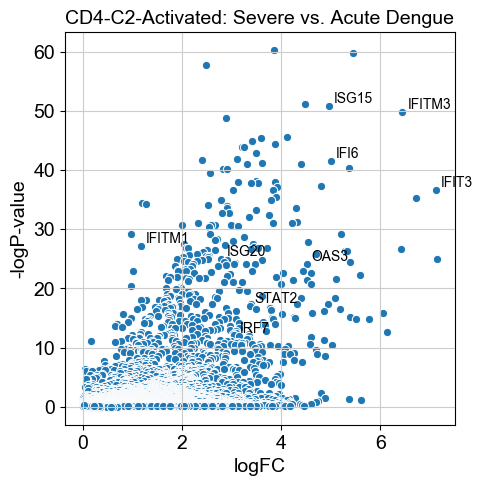

In [39]:
# Pull out genes to label
labels = ["IFITM3","IFI6","IFIT3","IFITM1", "ISG15", "ISG20", "STAT2", "IRF7", "OAS3" ]
labels_df = cd4_df.loc[cd4_df["names"].isin( labels )]
labels_df["logfoldchanges"] = labels_df["logfoldchanges"] + 0.1
labels_df["neglogpval_adj"] = labels_df["neglogpval_adj"] + 0.5

# Perform the plotting
plt.figure( dpi=100, figsize=(5,5) )
ax=plt.subplot()
sns.scatterplot( cd4_df["logfoldchanges"], cd4_df["neglogpval_adj"], ax=ax )
plt.xlabel( "logFC")
plt.ylabel( "-logP-value")
plt.title( "CD4-C2-Activated: Severe vs. Acute Dengue")
for i in labels_df.iterrows():
    ax.annotate( i[1]["names"], (i[1]["logfoldchanges"], i[1]["neglogpval_adj"]) )

We generally see the same genes that were upregulated in the CD8 cells upregulated in the activated CD4 cells. This might provide evidence for the cytokine storm but, given that the same genes were upregulated in both clusters, it might just be a result of a batch effect between the samples. It could also be argued that the inteferon response genes are upregulated because of the increased viremia associated with severe dengue. More evidence is obviously needed in either case.

We can additionally look at the expression of some of these genes in the three cohorts in order to determine whether they would be good biomarkers for severe dengue fever. Despite the high number of dengue infections across the world, there are no biomarkers to predict disease progression. Looking at expression in this manner is the first step in identifying which immune factors might be a good biomarker.

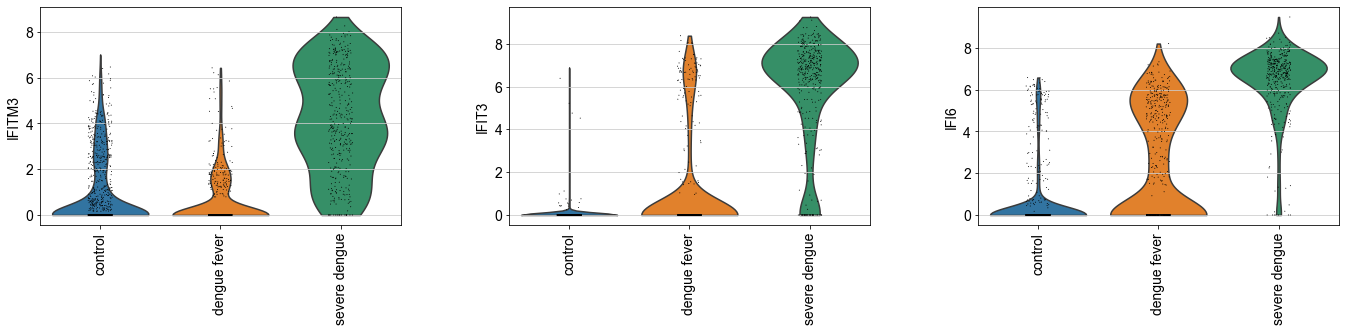

In [40]:
sc.pl.violin( scdata, keys=["IFITM3", "IFIT3", "IFI6"], use_raw=True, groupby="Disease_Status", rotation=90 )

Among the top hits, expression of *IFIT3* and *IFI6* in T cells appear to be the most suitable for use as biomarkers. Both differentiate severe dengue fever from actue cases and healthy individuals.  

# Summary:
In this tutorial we went throught the typical steps of a scRNA-seq analysis workflow. We started with general preprocessing of the data which included cell and gene quality control, normalization, batch correction, selection of highly variable genes, and visualization. In these steps we explored the data and filtered it so as to conservatively remove low quality data and optimize downstream analysis results. In downstream analyses we selected T cells through clustering, and characterized T cell subsets through subclustering and differentialy gene analysis. We then used these characterized T cell subsets to inform our analysis of dengue virus infection using compositional analysis and differential gene expression. 